In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  


sys.path.append('/Users/kemran/Desktop/work_files/python_files') 
from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [177]:
query = '''select renewal_off_date::date AS date, count(distinct user_id) as cnt_user
    from datamarts.marketing_dash mdd 
    WHERE 
    renewal_off_date::date BETWEEN '2025-05-01' AND '2025-06-15'
group by 1
order by 1
'''


df = execute(query,user='kmekhtiev')
df['date'] = df['date'].astype('datetime64[ns]')

Время выполнения функции: 0.9383 секунд



In [249]:
pwd

'/Users/kemran/Desktop/work_files/python_files/practice_files'

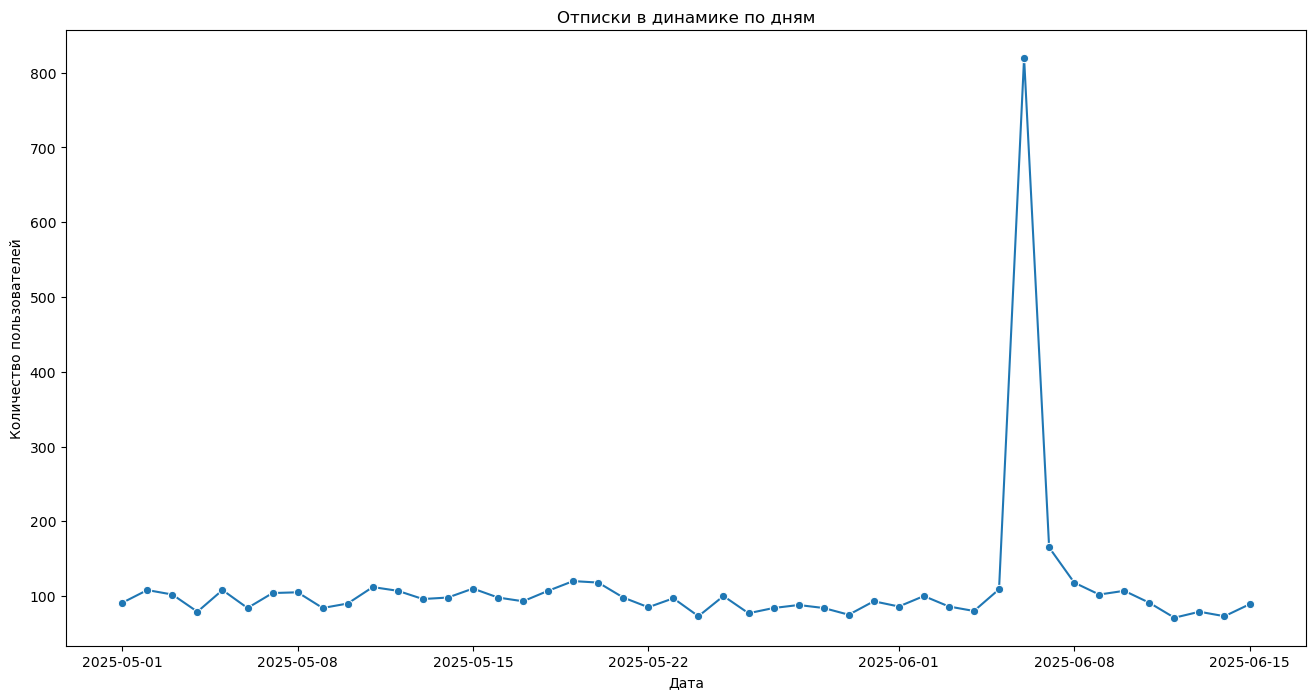

In [181]:
plt.figure(figsize=(16,8),dpi=100)
sns.lineplot(df,x='date',y='cnt_user',marker='o')
plt.ylabel('Количество пользователей')
plt.xlabel('Дата')
plt.title('Отписки в динамике по дням')

plt.show()

In [5]:
df_old = df[df['date']<'2025-06-06']
df_new_06_06 = df[df['date'].isin(['2025-06-06'])]
df_new_06_07 = df[df['date'].isin(['2025-06-07'])]

df_new = df[df['date'].isin(['2025-06-06','2025-06-07','2025-06-08','2025-06-09'])]

In [6]:
print(df_old['cnt_user'].std())
print(df_old['cnt_user'].mean())

12.343367861273931
95.61111111111111


In [7]:
df_old['cnt_user'].mean()

95.61111111111111

In [8]:
np.sqrt(len(df_old))

6.0

In [9]:
# Доверительный интервал до инцидента (95%)
c = stats.norm.ppf(1 - 0.05/2)
ci_left, ci_right = round(df_old['cnt_user'].mean() - c * df_old['cnt_user'].std() / np.sqrt(len(df_old)),0), round(df_old['cnt_user'].mean() + c * df_old['cnt_user'].std() / np.sqrt(len(df_old)),0)

# Среднее после инцидента
new_mean_06_06 = round(df_new_06_06['cnt_user'].mean(),0)
new_mean_06_07 = round(df_new_06_07['cnt_user'].mean(),0)

diff_06_06 = new_mean_06_06 - ci_right
diff_06_07 = new_mean_06_07 - ci_right


print(f"Доверительный интервал до инцидента: [{ci_left:.2f}, {ci_right:.2f}]")
print(f"Среднее после инцидента 06.06: {new_mean_06_06:.2f}")
print(f"Среднее после инцидента 06.07: {new_mean_06_07:.2f}")
print(f"Разница средних 06.06: {diff_06_06:.2f}")
print(f"Разница средних 06.07: {diff_06_07:.2f}")

Доверительный интервал до инцидента: [92.00, 100.00]
Среднее после инцидента 06.06: 831.00
Среднее после инцидента 06.07: 167.00
Разница средних 06.06: 731.00
Разница средних 06.07: 67.00


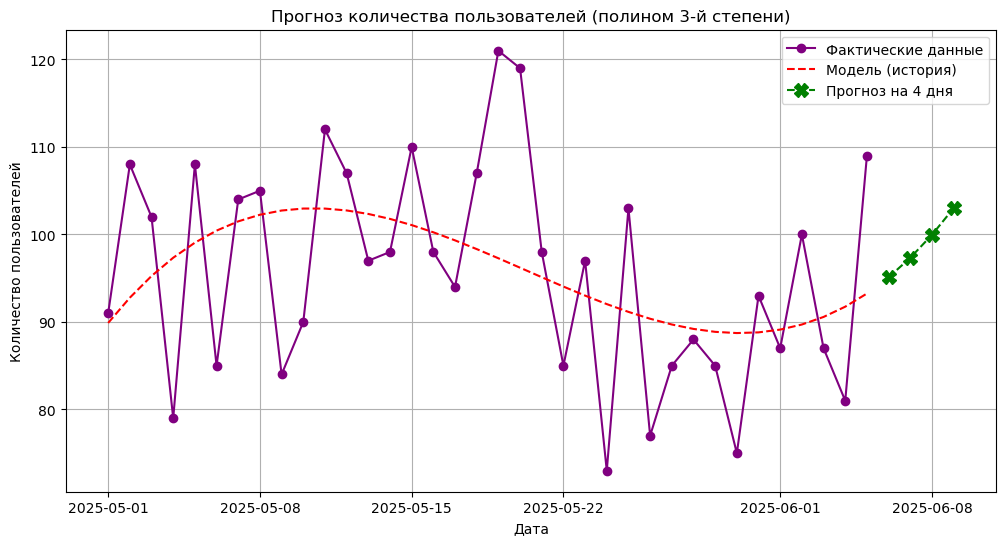

In [10]:
# Исходные данные
x = np.arange(len(df_old))  # 0, 1, 2, ..., N-1
y = df_old['cnt_user'].values

# Обучаем модель (кубическая регрессия)
degree = 3
coefficients = np.polyfit(x, y, degree)
poly_model = np.poly1d(coefficients)

# Прогноз на 2 точки вперед
future_steps = 4
x_future = np.arange(len(df_old), len(df_old) + future_steps)  # N, N+1, N+2
y_future = poly_model(x_future)  # прогнозные значения

# Генерация будущих дат
last_date = df_old['date'].iloc[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, future_steps+1)]

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df_old['date'], y, 'o-', color='purple', label='Фактические данные')
plt.plot(df_old['date'], poly_model(x), '--', color='red', label='Модель (история)')
plt.plot(future_dates, y_future, 'X--', color='green', markersize=10, label='Прогноз на 4 дня')
plt.title('Прогноз количества пользователей (полином 3-й степени)')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid(True)
plt.show()

# Вывод прогноза в табличном виде
future_df = pd.DataFrame({
    'date': future_dates,
    'predicted_cnt_user': y_future
})

future_df['predicted_cnt_user'] = future_df['predicted_cnt_user'].round(0)

In [11]:
df_merge = pd.merge(future_df,df_new,on='date',how='left')
df_merge['delta'] = round(df_merge['cnt_user'] - df_merge['predicted_cnt_user'],0)
df_merge

,date,predicted_cnt_user,cnt_user,delta
0,2025-06-06,95.0,831,736.0
1,2025-06-07,97.0,167,70.0
2,2025-06-08,100.0,119,19.0
3,2025-06-09,103.0,102,-1.0


In [209]:
query = '''SELECT renewal_off_date::date AS date, user_id, first_prolong_date::date AS first_prolong_date ,created_at::date AS created_at, reg_source
    FROM datamarts.marketing_dash mdd 
    WHERE renewal_off_date::date BETWEEN '2025-05-01' AND '2025-06-09'
'''


df = execute(query,user='kmekhtiev')
df['date'] = df['date'].astype('datetime64[ns]')
df['first_prolong_date'] = df['first_prolong_date'].astype('datetime64[ns]')
df['created_at'] = df['created_at'].astype('datetime64[ns]')

Время выполнения функции: 0.4829 секунд



In [211]:
df['paid_user'] = df['first_prolong_date'].apply(lambda x: 'Триал' if pd.to_datetime(x) == pd.Timestamp('1970-01-01') else 'Платящие')
df[(df['date']>='2025-06-06')].groupby('paid_user')['user_id'].count()

paid_user
Платящие    555
Триал       650
Name: user_id, dtype: int64

In [213]:
df[(df['date']<'2025-06-06')].groupby('paid_user')['user_id'].count()

paid_user
Платящие    1118
Триал       2311
Name: user_id, dtype: int64

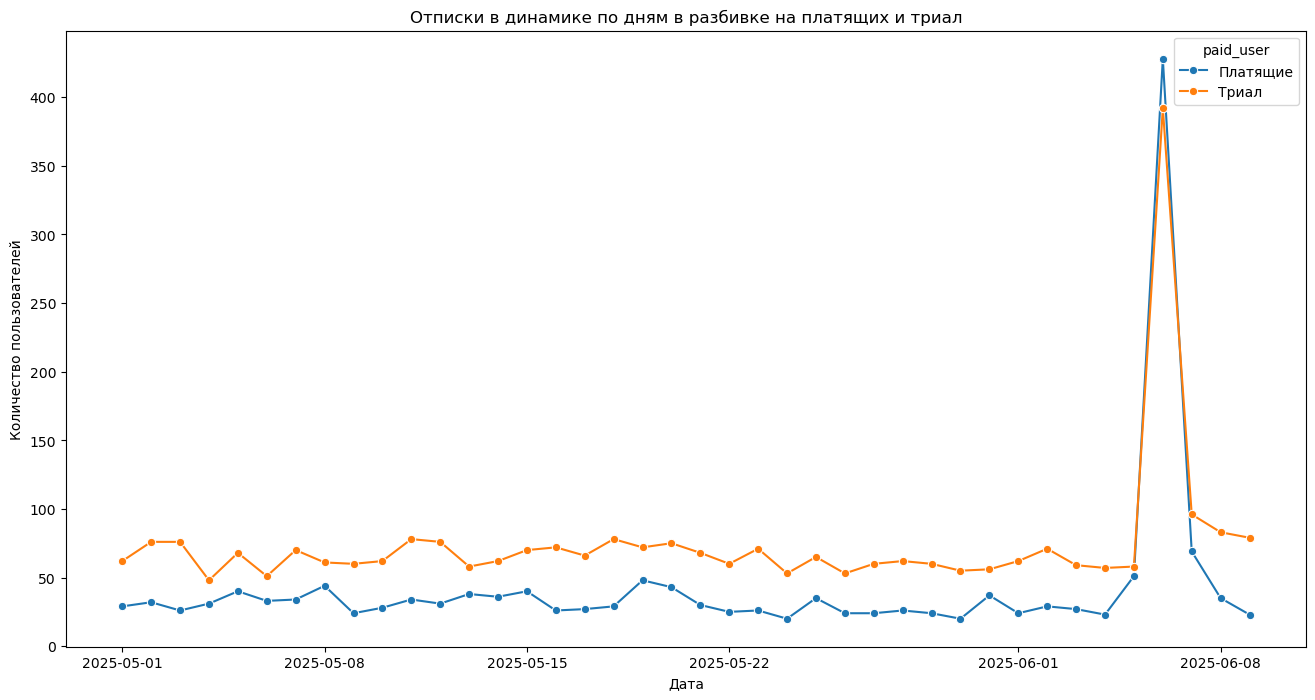

In [215]:
plt.figure(figsize=(16,8),dpi=100)
df_agg = df.groupby(['date','paid_user'])['user_id'].count().reset_index()
sns.lineplot(df_agg,x='date',y='user_id',marker='o',hue='paid_user')
plt.ylabel('Количество пользователей')
plt.xlabel('Дата')
plt.title('Отписки в динамике по дням в разбивке на платящих и триал')

plt.show()

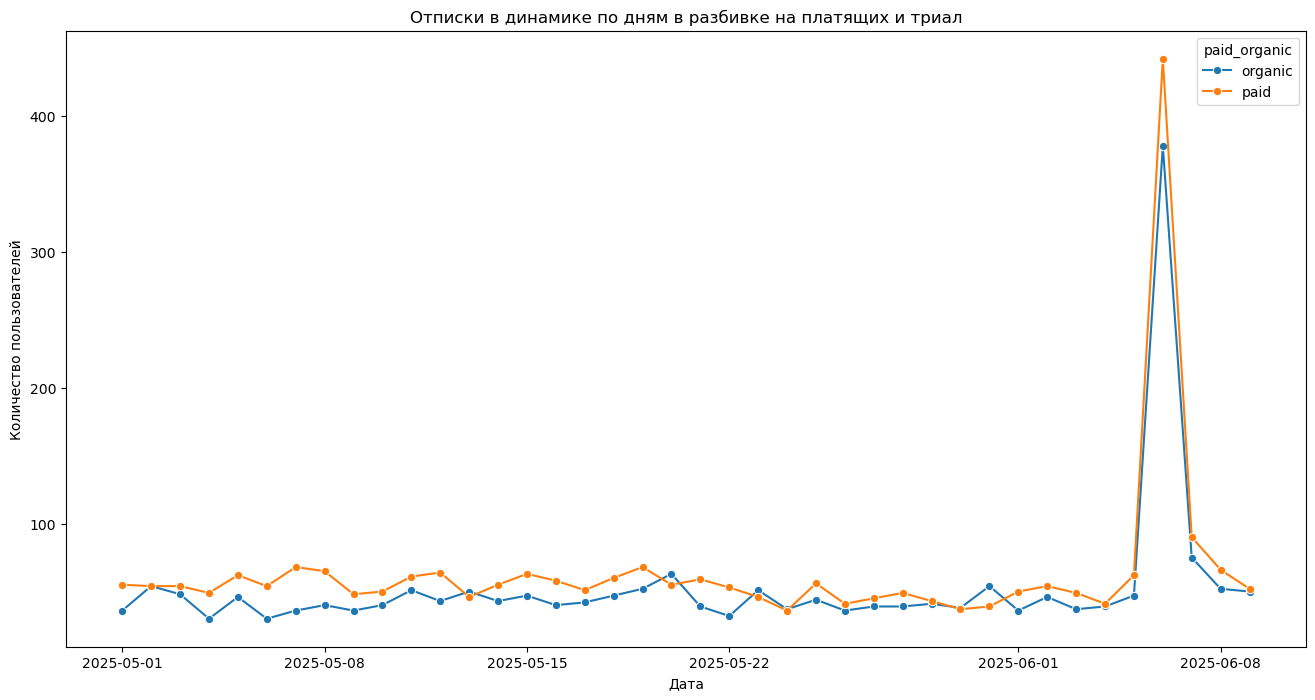

In [233]:
df['paid_organic'] = df['reg_source'].apply(lambda x:'organic' if x=='none' else 'paid')
df_agg = df.groupby(['date','paid_organic'])['user_id'].count().reset_index()


plt.figure(figsize=(16,8),dpi=100)
sns.lineplot(df_agg,x='date',y='user_id',marker='o',hue='paid_organic')
plt.ylabel('Количество пользователей')
plt.xlabel('Дата')
plt.title('Отписки в динамике по дням в разбивке на платящих и триал')

plt.show()

In [237]:
df_agg.tail(20)

,date,paid_organic,user_id
60,2025-05-31,organic,54
61,2025-05-31,paid,39
62,2025-06-01,organic,36
63,2025-06-01,paid,50
64,2025-06-02,organic,46
65,2025-06-02,paid,54
66,2025-06-03,organic,37
67,2025-06-03,paid,49
68,2025-06-04,organic,39
69,2025-06-04,paid,41


In [219]:
df_agg['reg_source'].apply(lambda x:'organic' if x=='none' else 'paid')

0         paid
1         paid
2         paid
3      organic
4         paid
        ...   
269       paid
270    organic
271       paid
272       paid
273       paid
Name: reg_source, Length: 274, dtype: object

In [177]:
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.dml.color import RGBColor

# Создаём презентацию
prs = Presentation()

# Слайд 1: Титульный
slide = prs.slides.add_slide(prs.slide_layouts[0])
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "Как продуктовая аналитика помогает принимать решения"
subtitle.text = "От интуиции к данным"

# Слайд 2: Проблема
slide = prs.slides.add_slide(prs.slide_layouts[1])
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "Почему интуиции недостаточно?"
content.text = "• Интуиция субъективна\n• Пример: баннер снизил конверсию\n• Данные дают объективную картину"

# Слайд 3: Пример метрики (First Play Rate)
slide = prs.slides.add_slide(prs.slide_layouts[1])
title = slide.shapes.title
content = slide.placeholders[1]
title.text = "First Play Rate: до и после"
content.text = "Было: 42%\nСтало: 58% (+16 п.п.)"

# Сохраняем
prs.save("product_analytics.pptx")
print("Презентация создана!")

Презентация создана!


# LTV

In [32]:
df[df['date']>'2025-06-06'].groupby('paid_user')['user_id'].nunique()

paid_user
Платящие    129
Триал       259
Name: user_id, dtype: int64

In [34]:
t = df[df['date']<'2025-06-06'].groupby(['date','paid_user'])['user_id'].nunique().reset_index()
t.groupby('paid_user')['user_id'].mean()

paid_user
Платящие    31.166667
Триал       64.444444
Name: user_id, dtype: float64

In [72]:
query = f''' 
        SELECT paid_date,user_id,date_trunc('month',min_date) AS min_mt,payment,cumulative_payment,offer_duration,rn_num
        FROM
        (SELECT 
         paid_date,
         user_id,
         offer_duration,
         min(paid_date) OVER (PARTITION BY user_id ORDER BY paid_date) AS min_date,payment,
         sum(payment) OVER (PARTITION BY user_id ORDER BY paid_date ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cumulative_payment,
         row_number() OVER (PARTITION BY user_id ORDER BY paid_date) AS rn_num
         FROM datamarts.finance AS t1
         LEFT JOIN datamarts.marketing_dash AS t2 on t1.user_id = t2.user_id
         )
         '''

df_payment = execute(query,user='kmekhtiev')

Время выполнения функции: 1.3241 секунд



In [74]:
pd.merge(df_payment,df[(df['date']>='2025-06-06') & (df['paid_user']=='Платящие')],how='inner',on='user_id')['payment'].sum() / pd.merge(df_payment,df[(df['date']>='2025-06-06') & (df['paid_user']=='Платящие')],how='inner',on='user_id')['user_id'].nunique()
                                                                                                

619.8327402135232

In [76]:
df_payment_merge = pd.merge(df_payment,df[(df['date']>='2025-06-06') & (df['paid_user']=='Платящие')],how='inner',on='user_id')

In [78]:
import pandas as pd
from dateutil.relativedelta import relativedelta


# текущий месяц для вычитания
current_month = pd.to_datetime('2025-05-01')

# функция для вычисления разницы в месяцах
def diff_in_months(date_series, reference_date):
    return date_series.apply(lambda x: (relativedelta(x, reference_date).years * 12) + relativedelta(x, reference_date).months)

# применение функции к столбцу min_dt
df_payment_merge['cohort'] = abs(diff_in_months(pd.to_datetime(df_payment_merge['min_mt']), current_month))
df_payment_merge['cohort'] = df_payment_merge['cohort'] + 1

In [80]:
df_payment_merge[df_payment_merge['cohort']==5]

,paid_date,user_id,min_mt,payment,cumulative_payment,offer_duration,rn_num,date,first_prolong_date,created_at,paid_user,cohort
9,2025-01-21,c38c13c5-3554-49a8-80cb-11d8a406daa1,2025-01-01,399,399,3 month,1,2025-06-06,2025-01-21,2024-12-17,Платящие,5
10,2025-04-21,c38c13c5-3554-49a8-80cb-11d8a406daa1,2025-01-01,399,798,3 month,2,2025-06-06,2025-01-21,2024-12-17,Платящие,5
22,2025-01-17,eea4e54f-6d47-467a-81c4-8199da54c4e8,2025-01-01,1190,1190,12 month,1,2025-06-06,2025-01-17,2025-01-14,Платящие,5
68,2025-01-14,03df0d11-d9b1-46fd-85cb-ee8189890d4a,2025-01-01,399,399,3 month,1,2025-06-06,2025-01-14,2024-12-11,Платящие,5
69,2025-04-14,03df0d11-d9b1-46fd-85cb-ee8189890d4a,2025-01-01,199,598,3 month,2,2025-06-06,2025-01-14,2024-12-11,Платящие,5
...,...,...,...,...,...,...,...,...,...,...,...,...
780,2025-01-14,43be55d2-2ad9-46f4-b913-798ee31138e3,2025-01-01,399,399,3 month,1,2025-06-06,2025-01-14,2024-12-10,Платящие,5
781,2025-04-14,43be55d2-2ad9-46f4-b913-798ee31138e3,2025-01-01,399,798,3 month,2,2025-06-06,2025-01-14,2024-12-10,Платящие,5
813,2025-01-07,4e46e95e-d3d9-40c8-bc82-ac44294b1532,2025-01-01,499,499,3 month,1,2025-06-06,2025-01-07,2025-01-04,Платящие,5
837,2025-01-11,ea7c11a0-cf57-4a87-bedc-ee180f89f206,2025-01-01,399,399,3 month,1,2025-06-06,2025-01-11,2024-12-07,Платящие,5


In [82]:
df_payment_merge[df_payment_merge['user_id']=='4e46e95e-d3d9-40c8-bc82-ac44294b1532']

,paid_date,user_id,min_mt,payment,cumulative_payment,offer_duration,rn_num,date,first_prolong_date,created_at,paid_user,cohort
813,2025-01-07,4e46e95e-d3d9-40c8-bc82-ac44294b1532,2025-01-01,499,499,3 month,1,2025-06-06,2025-01-07,2025-01-04,Платящие,5


In [84]:
df_payment_merge.groupby('offer_duration').agg({'user_id':'count','payment':'mean'})

,user_id,payment
offer_duration,,
1 month,289,215.605536
12 month,78,1159.294872
3 month,470,400.491489
6 month,11,670.909091


In [100]:
df_payment_merge[df_payment_merge['offer_duration']=='1 month'].groupby('rn_num').agg({'user_id':'count','payment':'mean'})

,user_id,payment
rn_num,,
1,170,174.376471
2,43,288.883721
3,20,278.500000
4,16,277.750000
5,9,261.222222
6,9,261.222222
7,5,271.000000
8,5,271.000000
9,2,264.000000


# Подключение подписок по часам 

In [113]:
query = f'''WITH money_table AS(
    SELECT 
        --paid_at::date AS paid_date,
        date_trunc('hour',paid_at) paid_hour,
        EXTRACT(HOUR FROM paid_hour) AS hour_only,
        toDate(paid_at) AS paid_date,
        s.user_id AS user_id,
        subscription_id,
        platform,
        i.price_cents AS price_cents,
        i.price_currency AS price_currency,
        CASE 
            WHEN i.price_currency='USD' THEN i.price_cents*usd_value/100
            WHEN i.price_currency='AMD' THEN i.price_cents*amd_value/100
            ELSE i.price_cents/100
        END bill,
        usd_value,
        amd_value
        
    FROM
        --product_x.invoices i
        raw.viju__product_x__public__invoices AS i

        LEFT JOIN
        --product_x.subscriptions s
        raw.viju__product_x__public__subscriptions AS s
        ON s.id = i.subscription_id

        LEFT JOIN
        --product_x.users u
        raw.viju__product_x__public__users AS u
        ON u.id = s.user_id

        LEFT JOIN
        raw.external__exchange_rate AS e
        --ON e.extract_date=i.paid_at::date
        ON e.extract_date=toDate(i.paid_at)
        
        INNER JOIN (SELECT user_id, first_prolong_date::date AS first_prolong_date
        			FROM datamarts.marketing_dash
        			) AS t2
        ON s.user_id =t2.user_id AND i.paid_at::date=t2.first_prolong_date
    WHERE
        u.user_type = 'regular'
        AND u.vipplay = FALSE
        AND s.state in ('normal_period','trial','canceled','grace_period')
        --AND i.paid_at::date='$date'::date
        AND toDate(i.paid_at) BETWEEN '2025-03-01'  AND '2025-05-31'
        AND i.state in ('success')
        AND (
            (u.email NOT ILIKE '%%@test%%' AND u.email NOT ILIKE '%%@viasat%%')
            OR (u.email IS NULL AND u.phone_number IS NOT NULL)
        )
        AND i.price_cents > 100
        AND platform = 'cloudpayments'
)

SELECT * FROM money_table
'''''

df_payment_hour = execute(query,user='kmekhtiev')

Время выполнения функции: 9.6864 секунд



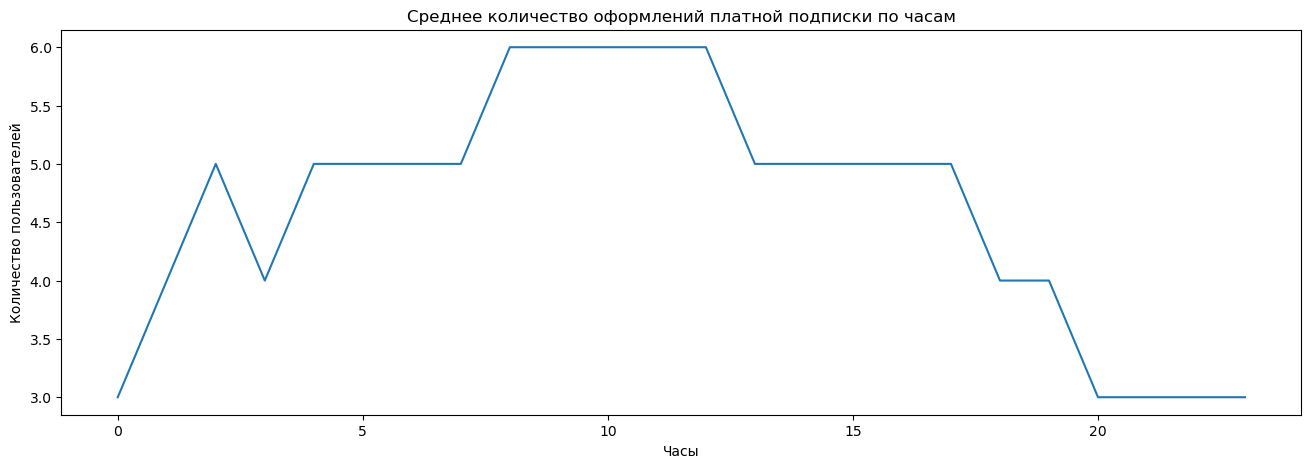

In [171]:
df_payment_hour_agg = df_payment_hour.groupby(['paid_date','hour_only']).agg({'user_id':'nunique','bill':'sum'}).reset_index()

t = df_payment_hour_agg.groupby('hour_only').agg({'user_id': 'mean', 'bill': 'mean'}).reset_index()

t[['user_id', 'bill']] = np.ceil(t[['user_id', 'bill']])

plt.figure(figsize=(16,5),dpi=100)
sns.lineplot(data = t, x='hour_only', y ='user_id')
plt.ylabel('Количество пользователей')
plt.xlabel('Часы')
plt.title('Среднее количество оформлений платной подписки по часам')

plt.show()

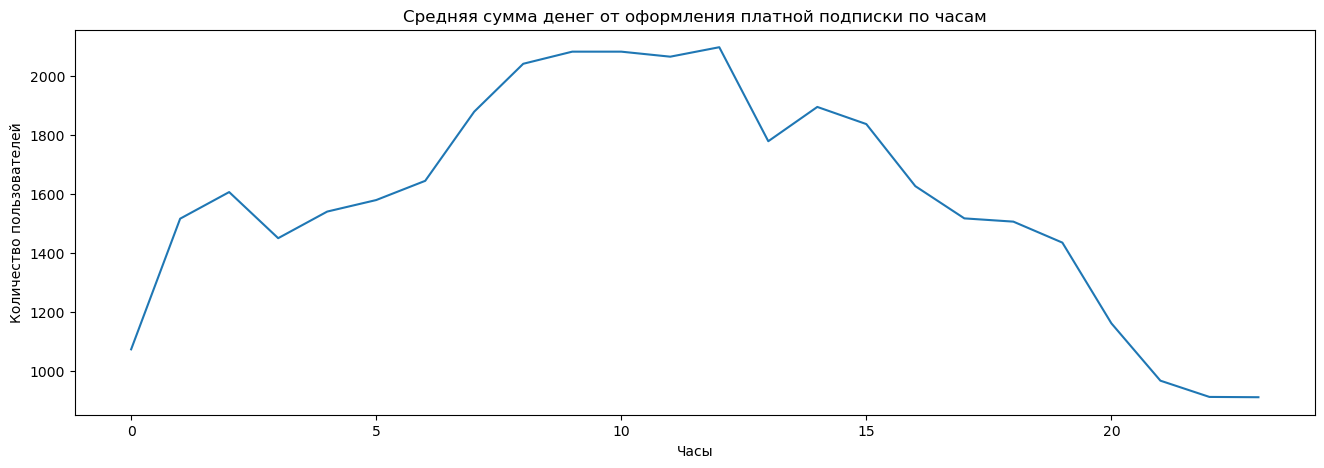

In [169]:
plt.figure(figsize=(16,5),dpi=100)

sns.lineplot(data = t, x='hour_only', y ='bill')
plt.ylabel('Количество пользователей')
plt.xlabel('Часы')
plt.title('Средняя сумма денег от оформления платной подписки по часам')

plt.show()

In [175]:
t

,hour_only,user_id,bill
0,0,3.0,1074.0
1,1,4.0,1516.0
2,2,5.0,1606.0
3,3,4.0,1450.0
4,4,5.0,1540.0
5,5,5.0,1579.0
6,6,5.0,1644.0
7,7,5.0,1878.0
8,8,6.0,2040.0
9,9,6.0,2081.0


In [193]:
query = f'''SELECT paid_date,user_id,date_trunc('month',min_date) AS min_mt,payment,cumulative_payment,offer_duration,rn_num
        FROM
        (SELECT 
         paid_date,
         user_id,
         offer_duration,
         min(paid_date) OVER (PARTITION BY user_id ORDER BY paid_date) AS min_date,payment,
         sum(payment) OVER (PARTITION BY user_id ORDER BY paid_date ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cumulative_payment,
         row_number() OVER (PARTITION BY user_id ORDER BY paid_date) AS rn_num
         FROM datamarts.finance AS t1
         LEFT JOIN datamarts.marketing_dash AS t2 on t1.user_id = t2.user_id
         )
         '''


df_cr_next_month = execute(query,user='kmekhtiev')
df_cr_next_month['min_mt'] = df_cr_next_month['min_mt'].astype('datetime64[ns]')

Время выполнения функции: 1.5144 секунд



In [197]:
df_cr_next_month[(df_cr_next_month['min_mt']<='2025-05-15') & (df_cr_next_month['offer_duration']=='1 month')]

,paid_date,user_id,min_mt,payment,cumulative_payment,offer_duration,rn_num
6,2024-06-09,b50a1a35-a712-4095-8001-e83ce7819f21,2024-06-01,299,299,1 month,1
9,2024-07-20,8d544cf8-2670-4261-8003-49f030adcdda,2024-07-01,299,299,1 month,1
10,2024-10-13,8d544cf8-2670-4261-8003-49f030adcdda,2024-07-01,299,598,1 month,2
11,2025-06-11,8d544cf8-2670-4261-8003-49f030adcdda,2024-07-01,399,997,1 month,3
13,2023-09-27,5a067a3d-9fce-4b54-8004-a529fbfb845c,2023-09-01,299,299,1 month,1
...,...,...,...,...,...,...,...
82079,2024-09-16,1d987b22-27e8-4711-bfff-ba65e9870592,2024-03-01,299,2093,1 month,7
82080,2024-10-16,1d987b22-27e8-4711-bfff-ba65e9870592,2024-03-01,299,2392,1 month,8
82081,2024-11-16,1d987b22-27e8-4711-bfff-ba65e9870592,2024-03-01,299,2691,1 month,9
82082,2024-12-16,1d987b22-27e8-4711-bfff-ba65e9870592,2024-03-01,299,2990,1 month,10


In [245]:
df_cr_next_month['next_value'] = df_cr_next_month.groupby('user_id')['rn_num'].shift(-1)

df_cr_next_month[df_cr_next_month['next_value']==2]

,paid_date,user_id,min_mt,payment,cumulative_payment,offer_duration,rn_num,next_value
9,2024-07-20,8d544cf8-2670-4261-8003-49f030adcdda,2024-07-01,299,299,1 month,1,2.0
13,2023-09-27,5a067a3d-9fce-4b54-8004-a529fbfb845c,2023-09-01,299,299,1 month,1,2.0
17,2025-04-24,c8fdbc72-bd12-44a8-8006-b4b5e1339cdc,2025-04-01,299,299,1 month,1,2.0
19,2024-11-25,8f2b2d2b-e361-43ea-8007-3aaaa1b77395,2024-11-01,399,399,3 month,1,2.0
21,2024-07-14,8e6dc3bc-224f-440b-8007-9bf9cf47b92b,2024-07-01,299,299,1 month,1,2.0
...,...,...,...,...,...,...,...,...
82045,2024-10-23,5f74fddb-6333-485a-bff7-0cf387d926ff,2024-10-01,399,399,3 month,1,2.0
82050,2023-12-31,67ba21ab-e75d-4ccc-bff8-bd2c04f838d9,2023-12-01,299,299,1 month,1,2.0
82065,2024-06-09,8b3168d5-cc9d-4a80-bffc-1d33f1636d36,2024-06-01,299,299,1 month,1,2.0
82073,2024-03-16,1d987b22-27e8-4711-bfff-ba65e9870592,2024-03-01,299,299,1 month,1,2.0
